In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Initializations
fs = 1000 ## Hz
N = 24 ## number of geophones
x1 = 10 ## nearest-offset
dx = 1 ## geophone spacing
du = 1/75 ## Scale factor for offset between traces 
# Forward set of seismix test
LoadData = np.loadtxt('SampleData.txt', dtype='float', delimiter=None)
DataCut = LoadData[:,:N]
u = np.zeros((np.size(DataCut,0), N), dtype=float)

for i in range(np.size(DataCut[:,0])):
    for j in range(np.size(DataCut[0,:])):        

        u[i,j] = DataCut[i,j]

Tmax = (1/fs) * (len(u[:,0]) - 1) ## total recording period [s]
T = np.linspace(0,Tmax,len(u[:,0])) ## time interval array
L = (N - 1) * dx
x = np.arange(x1, L + x1 + 1.0E-5, dx) ## start from nearest-offset x1

FigFontSize = 10

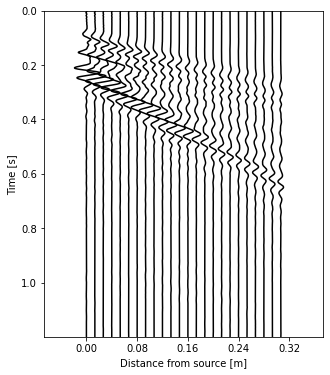

In [18]:
def MASW_plot_data(u, N, dx, L, T, Tmax, du, FigFontSize):
    SignalToPlot = np.zeros((np.size(u,0), N), dtype='float')
    fig, ax = plt.subplots(figsize=(5,6))
    
    for j in range(N):
        SignalToPlot[:,j] = u[:,j] + j * du * dx     
        
        plt.plot(SignalToPlot[:,j], T, 'k')
    ax.set_xlim(-5*dx*du,L*du+5*dx*du)
    ax.set_ylim(0,Tmax)
    ax.set_xlabel('Distance from source [m]', fontsize = FigFontSize)
    ax.set_ylabel('Time [s]', fontsize = FigFontSize)
    ax.set_xticks(np.arange(0,L*du+6*dx*du,6*dx*du))
    plt.gca().invert_yaxis()
    #plt.show()
    return SignalToPlot
SignalToPlot = MASW_plot_data(u,N,dx,L,T,Tmax,du,FigFontSize)
# Dispersion parameters
cT_min = 50 ## [m/s]
cT_max = 400 ## [m/s]
delta_cT = 1 ## [m/s]

In [19]:
def MASW_Despersion_image(u,N,fs,cT_min,cT_max,delta_cT):
    ## Converting measuring frequency from Hz to rad/sec
    omega_fs = 2 * np.pi * fs
    ## Number of samples in each trace
    Lu = len(u[:,0])
    ## Empty matrices with Lu lines and n columns
    U = np.zeros((Lu,N),dtype='complex')
    P = np.zeros((Lu,N),dtype='complex')
    Unorm = np.zeros((Lu,N),dtype='complex')
    ## Waveform decomposition (Fourier transform)
    for j in range(N):    
        U[:,j] = np.fft.fft(u[:,j])
    LU = len(U[:,0])
    ## Normalize U in offset and frequency domain
    ## Compute the phase spectrum of UnboundLocalError
    for j in range(N):
        for k in range(int(LU)):
            Unorm[k,j] = U[k,j] / np.abs(U[k,j])
        P[:,j] = np.exp(1j * (-np.angle(U[:,j])))
    ## Frequency range for U
    omega = (1/LU) * np.arange(0,LU+1,1) * omega_fs
    ## compute Slant-stack (summed) amplitude corresponding to
    ## each set of [omega, cT, A(omega,cT)]
    cT = np.arange(cT_min, cT_max + delta_cT, delta_cT)
    LcT = len(cT)
    ## Empty matrices with Lu lines and n columns
    c = np.zeros((LU, LcT))
    f = np.zeros((LU,LcT))
    A = np.zeros((LU,LcT))
    for j in range(int(LU)):
        for k in range(int(LcT)):
        ## Frequency (in [Hz]) corresponding to angular frequency omega
            f[j,k] = omega[j] / (2 * np.pi)
            ## Testing phase velocity [m/s]
            c[j,k] = cT[k]
            ## Determining the amount of phase shifts required to counterbalance
            ## the time delay corresponding to specific offsets for a given set 
            ## of omega and cT
            delta = omega[j] / cT[k]
            ## Applying the phase shifts (delta) to distinct traces of the 
            ## transformed shot gather
            ## Obtaining the (normalized) slant-stack (summed) amplitude
            ## corresponding to each set of omega and cT
            temp = 0
            for l in range(N):
                temp = temp + np.exp(-1j * delta * x[l]) * P[j,l]
            ## Compute absolute value and normalize with respect to number of 
            ## receiver
            A[j,k] = np.abs(temp) / N
    return f,c,A
f,c,A = MASW_Despersion_image(u,N,fs,cT_min,cT_max,delta_cT)
print('f\n{}\nc\n{}\nA\n{}'.format(f,c,A))
print('f_shape\n{}\nc_shape\n{}\nA_shape\n{}'.format(f.shape,c.shape,A.shape))

f
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.33333333e-01 8.33333333e-01 8.33333333e-01 ... 8.33333333e-01
  8.33333333e-01 8.33333333e-01]
 [1.66666667e+00 1.66666667e+00 1.66666667e+00 ... 1.66666667e+00
  1.66666667e+00 1.66666667e+00]
 ...
 [9.97500000e+02 9.97500000e+02 9.97500000e+02 ... 9.97500000e+02
  9.97500000e+02 9.97500000e+02]
 [9.98333333e+02 9.98333333e+02 9.98333333e+02 ... 9.98333333e+02
  9.98333333e+02 9.98333333e+02]
 [9.99166667e+02 9.99166667e+02 9.99166667e+02 ... 9.99166667e+02
  9.99166667e+02 9.99166667e+02]]
c
[[ 50.  51.  52. ... 398. 399. 400.]
 [ 50.  51.  52. ... 398. 399. 400.]
 [ 50.  51.  52. ... 398. 399. 400.]
 ...
 [ 50.  51.  52. ... 398. 399. 400.]
 [ 50.  51.  52. ... 398. 399. 400.]
 [ 50.  51.  52. ... 398. 399. 400.]]
A
[[0.83333333 0.83333333 0.83333333 ... 0.83333333 0.83333333 0.83333333]
 [0.2641439  0.26333619 0.26259152 ... 0.26411176 0.26412458 0.26413734]
 [0.31428587 0.30939

(60, 351) (60, 351) (60, 351)
fplot:
[[ 0.83333333  0.83333333  0.83333333 ...  0.83333333  0.83333333
   0.83333333]
 [ 1.66666667  1.66666667  1.66666667 ...  1.66666667  1.66666667
   1.66666667]
 [ 2.5         2.5         2.5        ...  2.5         2.5
   2.5       ]
 ...
 [48.33333333 48.33333333 48.33333333 ... 48.33333333 48.33333333
  48.33333333]
 [49.16666667 49.16666667 49.16666667 ... 49.16666667 49.16666667
  49.16666667]
 [50.         50.         50.         ... 50.         50.
  50.        ]]
cplot:
[[ 50.  51.  52. ... 398. 399. 400.]
 [ 50.  51.  52. ... 398. 399. 400.]
 [ 50.  51.  52. ... 398. 399. 400.]
 ...
 [ 50.  51.  52. ... 398. 399. 400.]
 [ 50.  51.  52. ... 398. 399. 400.]
 [ 50.  51.  52. ... 398. 399. 400.]]
Aplot:
[[0.2641439  0.26333619 0.26259152 ... 0.26411176 0.26412458 0.26413734]
 [0.31428587 0.30939367 0.30459021 ... 0.15679673 0.15681059 0.15682445]
 [0.31469162 0.31259047 0.31035556 ... 0.33128717 0.33141222 0.33153678]
 ...
 [0.12133235 0.18001

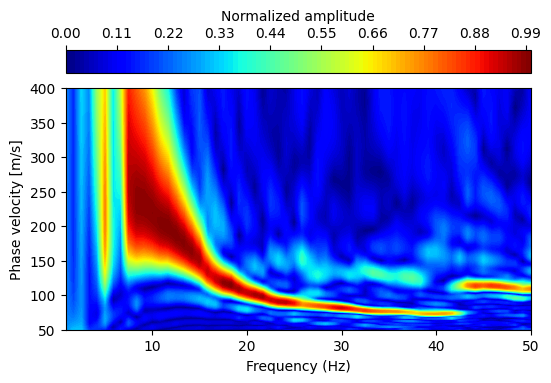

In [20]:
# Plot dispersion image
def MASW_plot_Dispersion_image(f,c,A):
    resolution = 100
    fmin = 1 ## Hz
    fmax = 50 ## Hz
    RemoveMin = np.abs((f[:,0] - fmin))
    RemoveMax = np.abs((f[:,0] - fmax))
    IdxMin = np.array(np.where(RemoveMin==np.min(RemoveMin))).flatten()[0]
    IdxMax = np.array(np.where(RemoveMax==np.min(RemoveMax))).flatten()[0]
    valMin, valMax = RemoveMin[IdxMin], RemoveMax[IdxMax]
    Aplot = A[IdxMin:IdxMax+1,:]
    fplot = f[IdxMin:IdxMax+1,:]
    cplot = c[IdxMin:IdxMax+1,:]
    fig, ax = plt.subplots(dpi=100)
    plt.contourf(fplot, cplot, Aplot, resolution, cmap=plt.cm.jet)    
    ax.set_xlabel('Frequency (Hz)', fontsize = FigFontSize)
    ax.set_ylabel('Phase velocity [m/s]', fontsize = FigFontSize)
    cbar = plt.colorbar(orientation='horizontal',location='top')
    cbar.set_label('Normalized amplitude', fontsize = FigFontSize)
    #plt.show()
    return valMin, valMax, IdxMin, IdxMax, fplot, cplot, Aplot
valMin, valMax, IdxMin, IdxMax, fplot, cplot, Aplot  = MASW_plot_Dispersion_image(f,c,A)
print(fplot.shape, cplot.shape, Aplot.shape)
print('fplot:\n{}\ncplot:\n{}\nAplot:\n{}'.format(fplot, cplot, Aplot))

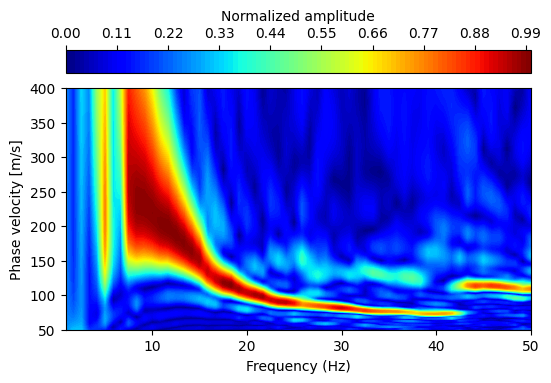

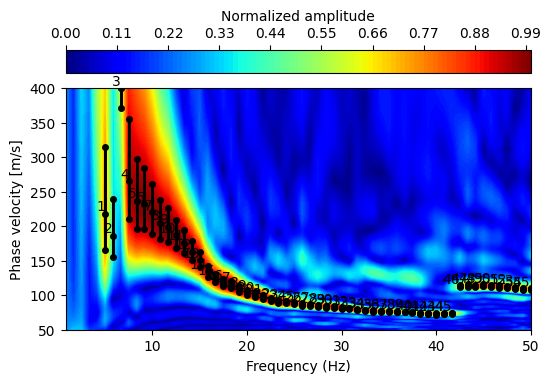

In [21]:
# Inversion analysis
def MASW_Extract_Dispersion_Curve(f,c,A):
    resolution = 100
    fmin = 1 ## Hz
    fmax = 50 ## Hz
    f_receivers = 4.5 ## Hz
    up_low_boundary = 'yes' ## The region, points inside supposed belonged to Fundamental DC
    p = 95 ## Percentage value for determination of upper/lower
    resolution = 100
    
    valMin, valMax, IdxMin, IdxMax, fplot, cplot, Aplot  = MASW_plot_Dispersion_image(f,c,A)
    Aabsnorm2 = np.zeros((Aplot.shape))
    
    for i in range(len(Aplot[:,0])):
        Aabsnorm2[i,:] = np.divide(Aplot[i,:] , np.max(Aplot[i,:]))
    
    loc = np.argwhere(Aabsnorm2.T==1)
    ## Reurn the first column is the search results on y-axis
    ## Rturn the second column is the search results on x-axis
    f_loc, c_loc = loc[:,1], loc[:,0]
    Amax_fvec = np.zeros((len(f_loc)))
    Amax_cvec = np.zeros((len(c_loc)))
        
    for i in range(len(f_loc)):
        Amax_fvec[i] = fplot[f_loc[i], 0]
        Amax_cvec[i] = cplot[0, c_loc[i]]
    ## Extract those values of freq. with max amplitude > freq. of receivers
    ii = np.where(Amax_fvec > f_receivers)
    Amax_fvec = Amax_fvec[ii]
    Amax_cvec = Amax_cvec[ii]
    ## Sort freq. vectore of max amplitude in order
    jj = np.argsort(Amax_fvec) ## return list of sorted indices
    Amax_fvec_sort = np.zeros((len(jj)))
    Amax_cvec_sort = np.zeros((len(jj)))  
    Amax_fvec_sort = Amax_fvec[jj] 
    Amax_cvec_sort = Amax_cvec[jj]
        
    if up_low_boundary == 'yes':
        
        loc_p = np.argwhere(Aabsnorm2.T > p/100)
        f_loc_p, c_loc_p = loc_p[:,1], loc_p[:,0]
        
        Amax_fvec_p = np.zeros((f_loc_p.shape))
        Amax_cvec_p = np.zeros((c_loc_p.shape))
        
        for i in range(len(f_loc_p)):                
            Amax_fvec_p[i] = fplot[f_loc_p[i], 0]
            Amax_cvec_p[i] = cplot[0,c_loc_p[i]]
        
        ## Search higher reveiver frequenct components
        kk = np.where(Amax_fvec_p > f_receivers)
        Amax_fvec_p = Amax_fvec_p[kk]
        Amax_cvec_p = Amax_cvec_p[kk]
        pp = np.argsort(Amax_fvec_p)
        Amax_fvec_sort_p = Amax_fvec_p[pp]
        Amax_cvec_sort_p = Amax_cvec_p[pp]
        ## Compute up-low-boundary points
        Amax_fvec_sort_p_cell = np.empty((len(np.unique(Amax_fvec_sort_p)), 1),dtype=object)
        Amax_cvec_sort_p_cell = np.empty((len(np.unique(Amax_fvec_sort_p)), 1),dtype=object)
        f_curve0_up_temp = np.zeros((len(np.unique(Amax_fvec_sort_p)),1))
        c_curve0_up_temp = np.zeros((len(np.unique(Amax_fvec_sort_p)),1))
        f_curve0_low_temp = np.zeros((len(np.unique(Amax_fvec_sort_p)),1))
        c_curve0_low_temp = np.zeros((len(np.unique(Amax_fvec_sort_p)),1))
        
        U = np.unique(Amax_fvec_sort_p, return_index=False) ## return index's sorted order
        Unique_Amax_fvec_sort_p = np.empty((len(U),1),dtype=object)
        
        for i in range(len(U)):
                        
            ## Store each ndarray in a cell (dtype = object)
            Amax_fvec_sort_p_cell[i][0] = Amax_fvec_sort_p[np.where(Amax_fvec_sort_p==U[i])]
            Amax_cvec_sort_p_cell[i][0] = Amax_cvec_sort_p[np.where(Amax_fvec_sort_p==U[i])]
            f_curve0_up_temp[i] = np.max(Amax_fvec_sort_p_cell[i][0])
            c_curve0_up_temp[i] = np.max(Amax_cvec_sort_p_cell[i][0])
            f_curve0_low_temp[i] = np.min(Amax_fvec_sort_p_cell[i][0])
            c_curve0_low_temp[i] = np.min(Amax_cvec_sort_p_cell[i][0])
    
    fig, ax = plt.subplots(dpi=100)
    plt.contourf(fplot, cplot, Aplot, resolution, cmap=plt.cm.jet)    
    #ax.set_xticks(np.arange(0,10+1E-5,fmax+0.01))
    #ax.set_xlim(fmin,fmax)
    ax.set_xlabel('Frequency (Hz)', fontsize = FigFontSize)
    ax.set_ylabel('Phase velocity [m/s]', fontsize = FigFontSize)
    
    cbar = plt.colorbar(orientation='horizontal',location='top')
    cbar.set_label('Normalized amplitude', fontsize = FigFontSize)
    
    plt.plot(Amax_fvec_sort, Amax_cvec_sort, 'o',\
             markersize=4,markerfacecolor='k',markeredgecolor='k')   
    
    plt.plot(Amax_fvec_sort_p,Amax_cvec_sort_p,'o',\
            markersize=1,markerfacecolor='k',markeredgecolor='k')
    ## Plot up-low boundary
    
    plt.plot(f_curve0_up_temp,c_curve0_up_temp, 'o',\
             markersize=4,markerfacecolor='k',markeredgecolor='k')
    plt.plot(f_curve0_low_temp, c_curve0_low_temp,'o',\
             markersize=4,markerfacecolor='k',markeredgecolor='k')
    
    labels = np.arange(1,len(Amax_fvec_sort)+1,1)
    
    for i, addtext in enumerate(labels):
        ax.annotate(addtext, (Amax_fvec_sort[i], Amax_cvec_sort[i]),\
        horizontalalignment='right', verticalalignment='bottom')
        
    ##plt.show()
    lower_freq = 4
    higher_freq = 43
    nP0 = np.arange(lower_freq, higher_freq+1,1)
    f_curve0 = Amax_fvec_sort[nP0]
    c_curve0 = Amax_cvec_sort[nP0]
    if up_low_boundary == 'yes':
        f_curve0_up = f_curve0_up_temp[nP0]
        c_curve0_up = c_curve0_up_temp[nP0]
        f_curve0_low = f_curve0_low_temp[nP0]
        c_curve0_low = c_curve0_low_temp[nP0]
    
    lambda_curve0 = np.divide(c_curve0, f_curve0)
    
    if up_low_boundary == 'yes':
        lambda_curve0_up = np.divide(c_curve0_up, f_curve0_up)
        lambda_curve0_low = np.divide(c_curve0_low, f_curve0_low)
    return  f_curve0,c_curve0,lambda_curve0,f_curve0_up,c_curve0_up,lambda_curve0_up,\
    f_curve0_low,c_curve0_low,lambda_curve0_low

f_curve0,c_curve0,lambda_curve0,f_curve0_up,c_curve0_up,lambda_curve0_up,f_curve0_low,\
c_curve0_low,lambda_curve0_low = MASW_Extract_Dispersion_Curve(f,c,A) 


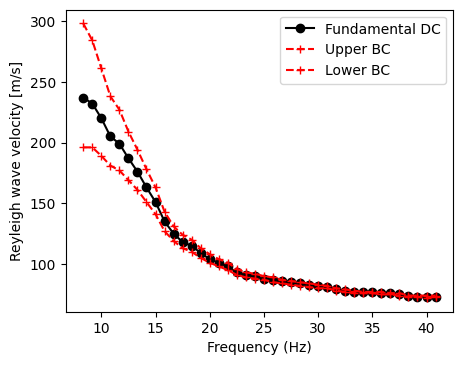

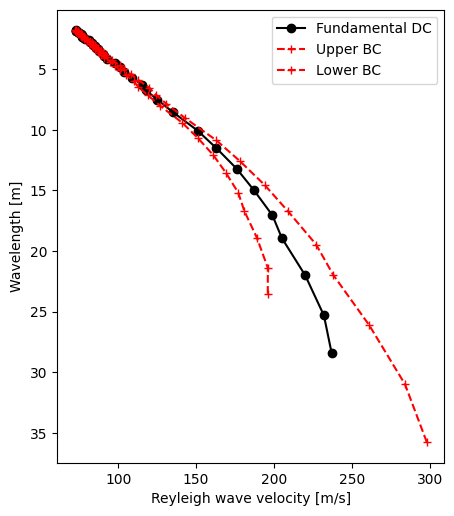

In [22]:
def MASW_plot_DC(f_curve0,c_curve0,lambda_curve0,f_curve0_up,c_curve0_up,\
    lambda_curve0_up,f_curve0_low,c_curve0_low,lambda_curve0_low):
    ## types of plots to display
    plot_f_c ='f_c'
    plot_lambda_c = 'lambda_c'
    if plot_f_c == 'f_c':
        fig, ax = plt.subplots(figsize=(5,4),dpi=100)
        ax.plot(f_curve0,c_curve0,'ko-')
        ax.plot(f_curve0_up,c_curve0_up,'r+--')
        ax.plot(f_curve0_low,c_curve0_low,'r+--')
        ax.set_xlabel('Frequency (Hz)', fontsize = FigFontSize)
        ax.set_ylabel('Reyleigh wave velocity [m/s]', fontsize = FigFontSize)
        ax.legend(['Fundamental DC','Upper BC','Lower BC'],loc='upper right')
    if plot_lambda_c == 'lambda_c':
        fig, ax = plt.subplots(figsize=(5,6),dpi=100)
        ax.plot(c_curve0,lambda_curve0, 'ko-')
        ax.plot(c_curve0_up,lambda_curve0_up,'r+--')
        ax.plot(c_curve0_low,lambda_curve0_low,'r+--')
        plt.gca().invert_yaxis()
        ax.set_xlabel('Reyleigh wave velocity [m/s]', fontsize = FigFontSize)
        ax.set_ylabel('Wavelength [m]', fontsize = FigFontSize)
        ax.legend(['Fundamental DC','Upper BC','Lower BC'],loc='upper right')
    plt.show()
    
MASW_plot_DC(f_curve0,c_curve0,lambda_curve0,f_curve0_up,c_curve0_up,lambda_curve0_up,\
f_curve0_low,c_curve0_low,lambda_curve0_low)

In [23]:
print(lambda_curve0)
print(f_curve0)

[28.44       25.30909091 22.         18.92307692 17.05714286 14.96
 13.2        11.50588235 10.06666667  8.52631579  7.5         6.74285714
  6.27272727  5.68695652  5.2         4.848       4.52307692  4.13333333
  3.9         3.72413793  3.52        3.36774194  3.225       3.09090909
  2.96470588  2.84571429  2.73333333  2.62702703  2.49473684  2.4
  2.31        2.25365854  2.2         2.12093023  2.07272727  2.
  1.93043478  1.86382979  1.825       1.7877551 ]
[ 8.33333333  9.16666667 10.         10.83333333 11.66666667 12.5
 13.33333333 14.16666667 15.         15.83333333 16.66666667 17.5
 18.33333333 19.16666667 20.         20.83333333 21.66666667 22.5
 23.33333333 24.16666667 25.         25.83333333 26.66666667 27.5
 28.33333333 29.16666667 30.         30.83333333 31.66666667 32.5
 33.33333333 34.16666667 35.         35.83333333 36.66666667 37.5
 38.33333333 39.16666667 40.         40.83333333]
